# **1. Tiền xử lý dữ liệu**






In [ ]:
'''
%%capture
import sys

if 'google.colab' in sys.modules:       #Chỉ cài gói khi chạy trong Colab
    !pip install category_encoders==2.* #Mã hóa biến phân loại (Categorical Encoding).
    !pip install eli5                   #Giải thích mô hình ML
    !pip install pandas-profiling==2.*  #Tạo báo cáo tự động cho tập dữ liệu (EDA nhanh).
    !pip install pdpbox                 #Partial Dependence Plots (hiển thị tác động của biến trong mô hình ML).
    !pip install shap                   #Giải thích độ quan trọng của đặc trưng (SHAP values).
'''

"\n%%capture\nimport sys\n\nif 'google.colab' in sys.modules:       #Chỉ cài gói khi chạy trong Colab\n    !pip install category_encoders==2.* #Mã hóa biến phân loại (Categorical Encoding).\n    !pip install eli5                   #Giải thích mô hình ML\n    !pip install pandas-profiling==2.*  #Tạo báo cáo tự động cho tập dữ liệu (EDA nhanh).\n    !pip install pdpbox                 #Partial Dependence Plots (hiển thị tác động của biến trong mô hình ML).\n    !pip install shap                   #Giải thích độ quan trọng của đặc trưng (SHAP values).\n"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import warnings
warnings.filterwarnings(action='ignore') #Ẩn các cảnh báo không cần thiết

## 1.1. Download dữ liệu từ kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kristhecoder/youtube-revenue-data-20182021")

Using Colab cache for faster access to the 'youtube-revenue-data-20182021' dataset.


## 1.2. Đọc dữ liệu vào, mô tả cấu trúc và thống kê sơ bộ về dữ liệu

In [ ]:
csv_names = ['Table data 2018.csv', 'Table data 2019.csv', 'Table data 2020.csv']

# Nối các dataframe từ các năm khác nhau, bỏ qua hàng đầu tiên và hàng cuối cùng của mỗi dataframe.
df = pd.concat((pd.read_csv(path+'/'+csv_names[0])[1:-1],
                pd.read_csv(path+'/'+csv_names[1])[1:-1],
                pd.read_csv(path+'/'+csv_names[2])[1:-1])).reset_index(drop=True)

df.columns = df.columns.str.replace(' ', '_')
col_map ={'Av\xader\xadage_views_per_view\xader':'Average_views_per_viewer',
          'Unique_view\xaders':'Unique_viewers',
          'Av\xader\xadage_per\xadcent\xadage_viewed_(%)':'Average_viewed_(%)',
          'Im\xadres\xadsions':'Impressions',
          'Dis\xadlikes':'Dislikes',
          'Sub\xadscribers_lost':'Subscribers_lost',
          'Sub\xadscribers_gained':'Subscribers_gained',
          'Videos_pub\xadlished':'Videos_added',
          'Videos_ad\xadded':'Videos_published',
          'Sub\xadscribers':'Subscribers',
          'Im\xadres\xadsions_click-through_rate_(%)':'Click_rate',
          'Com\xadments_ad\xadded':'Comments',
          'Watch_time_(hours)':'Watch_hours',
          'Av\xader\xadage_view_dur\xada\xadtion':'Average_view_sec',
          'Your_es\xadt\xadim\xadated_rev\xaden\xadue_(USD)':'Revenue'}
df = df.rename(columns=col_map)
df = df.drop(['Likes_(vs._dis­likes)_(%)',   # Đã có cột Likes và Dislikes
              'Videos_added',               # Không ảnh hưởng doanh thu
              'Subscribers_lost',           # Đã có cột Subsribers = Subscribers_gained - Subscribers_lost
              'Subscribers_gained'], axis=1)

print("2018-2020 YouTuber Daily Data")
print("="*45)
print('Data Size: ', df.shape)
print('Null Values: ', df.isna().sum().sum())
print('Data types: ', df.dtypes.reset_index().groupby(0).count().reset_index().values.tolist())
display(df.info())

2018-2020 YouTuber Daily Data
Data Size:  (1132, 16)
Null Values:  141
Data types:  [[dtype('float64'), 14], [dtype('O'), 2]]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132 entries, 0 to 1131
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  1132 non-null   object 
 1   Average_views_per_viewer              1132 non-null   float64
 2   Unique_viewers                        1132 non-null   float64
 3   Im­pres­sions_click-through_rate_(%)  1132 non-null   float64
 4   Im­pres­sions                         1132 non-null   float64
 5   Comments                              1132 non-null   float64
 6   Shares                                1132 non-null   float64
 7   Dislikes                              1132 non-null   float64
 8   Likes                                 1132 non-null   float64
 9   Average_viewed_(%)       

None

In [ ]:
display(df.head())

#Thống kê sơ bộ dữ liệu
display(df.describe())

,Date,Average_views_per_viewer,Unique_viewers,Im­pres­sions_click-through_rate_(%),Im­pres­sions,Comments,Shares,Dislikes,Likes,Average_viewed_(%),Videos_published,Subscribers,Views,Watch_hours,Average_view_sec,Your_es­tim­ated_rev­en­ue_(USD)
0,2018-08-21,1.1538,13.0,7.38,122.0,2.0,1.0,0.0,5.0,53.59,1.0,5.0,15.0,0.4666,0:01:51,0.0
1,2018-08-22,1.1935,31.0,23.14,121.0,3.0,0.0,0.0,4.0,44.58,NaN,4.0,37.0,0.9575,0:01:33,0.0
2,2018-08-23,1.3684,19.0,20.65,92.0,1.0,0.0,0.0,5.0,38.75,NaN,2.0,26.0,0.5849,0:01:20,0.0
3,2018-08-24,1.0000,8.0,13.64,44.0,0.0,0.0,0.0,0.0,24.81,NaN,0.0,8.0,0.1152,0:00:51,0.0
4,2018-08-25,1.0625,16.0,13.89,72.0,0.0,0.0,0.0,0.0,45.50,NaN,1.0,17.0,0.4491,0:01:35,0.0


,Average_views_per_viewer,Unique_viewers,Im­pres­sions_click-through_rate_(%),Im­pres­sions,Comments,Shares,Dislikes,Likes,Average_viewed_(%),Videos_published,Subscribers,Views,Watch_hours,Your_es­tim­ated_rev­en­ue_(USD)
count,1132.000000,1132.000000,1132.000000,1.132000e+03,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,991.000000,1132.000000,1132.000000,1132.000000,1132.000000
mean,1.627234,25396.726148,6.568640,8.335591e+05,224.119258,123.036219,39.393993,2788.837456,28.777359,0.172553,507.715548,51973.775618,3914.129724,19.523801
std,0.325841,54910.406132,2.246657,1.878691e+06,737.013531,333.979856,81.494291,7468.640081,6.136640,0.487721,1068.715498,115197.396189,9274.014141,46.704338
min,1.000000,8.000000,3.520000,4.400000e+01,0.000000,0.000000,-1.000000,-1.000000,10.950000,0.000000,-8.000000,8.000000,0.115200,0.000000
25%,1.426950,457.500000,5.167500,8.469000e+03,2.000000,2.000000,0.750000,15.000000,24.227500,0.000000,6.000000,654.500000,22.515175,0.200750
50%,1.556750,4115.000000,6.110000,6.886200e+04,28.000000,22.000000,6.000000,257.500000,28.095000,0.000000,118.000000,6450.500000,297.368850,1.582000
75%,1.791150,18102.500000,7.122500,3.985808e+05,128.250000,87.000000,31.000000,1246.250000,32.550000,0.000000,414.500000,27879.500000,1617.529875,9.069250
max,2.615800,482254.000000,23.140000,1.632350e+07,11582.000000,6513.000000,664.000000,63543.000000,62.190000,4.000000,10297.000000,954121.000000,73470.409300,397.066000


## 1.3. Chuẩn hóa dữ liệu thông qua xử lý dữ liệu lỗi (thiếu trường, sai định dạng dữ liệu, giá trị không hợp lệ ...)

### 1.3.1. Kiểm tra các cột có giá trị thiếu và quyết định chiến lược xử lý (ví dụ: điền giá trị trung bình, trung vị, mode, hoặc xóa hàng/cột).


In [ ]:
print("Số lượng giá trị thiếu mỗi cột:")
df.isna().sum().reset_index().style.highlight_min()

Số lượng giá trị thiếu mỗi cột:


,index,0
0,Date,0
1,Average_views_per_viewer,0
2,Unique_viewers,0
3,Im­pres­sions_click-through_rate_(%),0
4,Im­pres­sions,0
5,Comments,0
6,Shares,0
7,Dislikes,0
8,Likes,0
9,Average_viewed_(%),0


In [ ]:
# Fill missing values in 'Videos_published' with 0
df['Videos_published'] = df['Videos_published'].fillna(0)

# Check missing values again to confirm the strategy was effective
print("Missing values after handling:")
df.isna().sum().reset_index().style.highlight_min()

Missing values after handling:


,index,0
0,Date,0
1,Average_views_per_viewer,0
2,Unique_viewers,0
3,Im­pres­sions_click-through_rate_(%),0
4,Im­pres­sions,0
5,Comments,0
6,Shares,0
7,Dislikes,0
8,Likes,0
9,Average_viewed_(%),0


### 1.3.2. Chuyển đổi dữ liệu về dạng phù hợp

In [ ]:
df.select_dtypes(include=('object')).head(2)


,Date,Average_view_sec
0,2018-08-21,0:01:51
1,2018-08-22,0:01:33


In [ ]:
# Chuyển đổi cột 'Date' sang định dạng ngày giờ và cột 'Average_view_sec' sang tổng số giây.
df['Date'] = pd.to_datetime(df['Date'])

def time_string_to_seconds(time_str):
    if isinstance(time_str, str):
        parts = time_str.split(':')
        if len(parts) == 3:
            h, m, s = map(int, parts)
            return h * 3600 + m * 60 + s
        elif len(parts) == 2:
            m, s = map(int, parts)
            return m * 60 + s
    return None # Handle cases that are not strings or in expected formats

df['Average_view_sec'] = df['Average_view_sec'].apply(time_string_to_seconds).astype(float)

print("Data types after conversion:")
print(df.dtypes)
display(df.head())

Data types after conversion:
Date                                    datetime64[ns]
Average_views_per_viewer                       float64
Unique_viewers                                 float64
Im­pres­sions_click-through_rate_(%)           float64
Im­pres­sions                                  float64
Comments                                       float64
Shares                                         float64
Dislikes                                       float64
Likes                                          float64
Average_viewed_(%)                             float64
Videos_published                               float64
Subscribers                                    float64
Views                                          float64
Watch_hours                                    float64
Average_view_sec                               float64
Your_es­tim­ated_rev­en­ue_(USD)               float64
dtype: object


,Date,Average_views_per_viewer,Unique_viewers,Im­pres­sions_click-through_rate_(%),Im­pres­sions,Comments,Shares,Dislikes,Likes,Average_viewed_(%),Videos_published,Subscribers,Views,Watch_hours,Average_view_sec,Your_es­tim­ated_rev­en­ue_(USD)
0,2018-08-21,1.1538,13.0,7.38,122.0,2.0,1.0,0.0,5.0,53.59,1.0,5.0,15.0,0.4666,111.0,0.0
1,2018-08-22,1.1935,31.0,23.14,121.0,3.0,0.0,0.0,4.0,44.58,0.0,4.0,37.0,0.9575,93.0,0.0
2,2018-08-23,1.3684,19.0,20.65,92.0,1.0,0.0,0.0,5.0,38.75,0.0,2.0,26.0,0.5849,80.0,0.0
3,2018-08-24,1.0000,8.0,13.64,44.0,0.0,0.0,0.0,0.0,24.81,0.0,0.0,8.0,0.1152,51.0,0.0
4,2018-08-25,1.0625,16.0,13.89,72.0,0.0,0.0,0.0,0.0,45.50,0.0,1.0,17.0,0.4491,95.0,0.0


Xem mức tương quan giữa cột Your_estimated_revenue(USD) và các cột dạng số khác

In [ ]:
# Select only numerical columns before calculating correlation
numerical_df = df.select_dtypes(include=np.number)

# Calculate correlation and sort by Revenue
correlation_with_revenue = numerical_df.corr()['Your_es­tim­ated_rev­en­ue_(USD)'].sort_values(ascending=False)

# Display the correlation, excluding the correlation of Revenue with itself
display(correlation_with_revenue.reset_index()[1:].style.bar(align='mid'))

,index,Your_es­tim­ated_rev­en­ue_(USD)
1,Watch_hours,0.984514
2,Unique_viewers,0.978712
3,Views,0.976545
4,Likes,0.964728
5,Dislikes,0.963711
6,Im­pres­sions,0.941682
7,Subscribers,0.907303
8,Comments,0.830628
9,Shares,0.812967
10,Average_view_sec,0.646830


### 1.3.3. Xử lý giá trị không hợp lệ hoặc ngoại lai




Xác định các cột số và trực quan hóa các giá trị ngoại lai bằng biểu đồ hộp để hiểu sự phân bố và các giá trị cực trị tiềm ẩn của chúng.



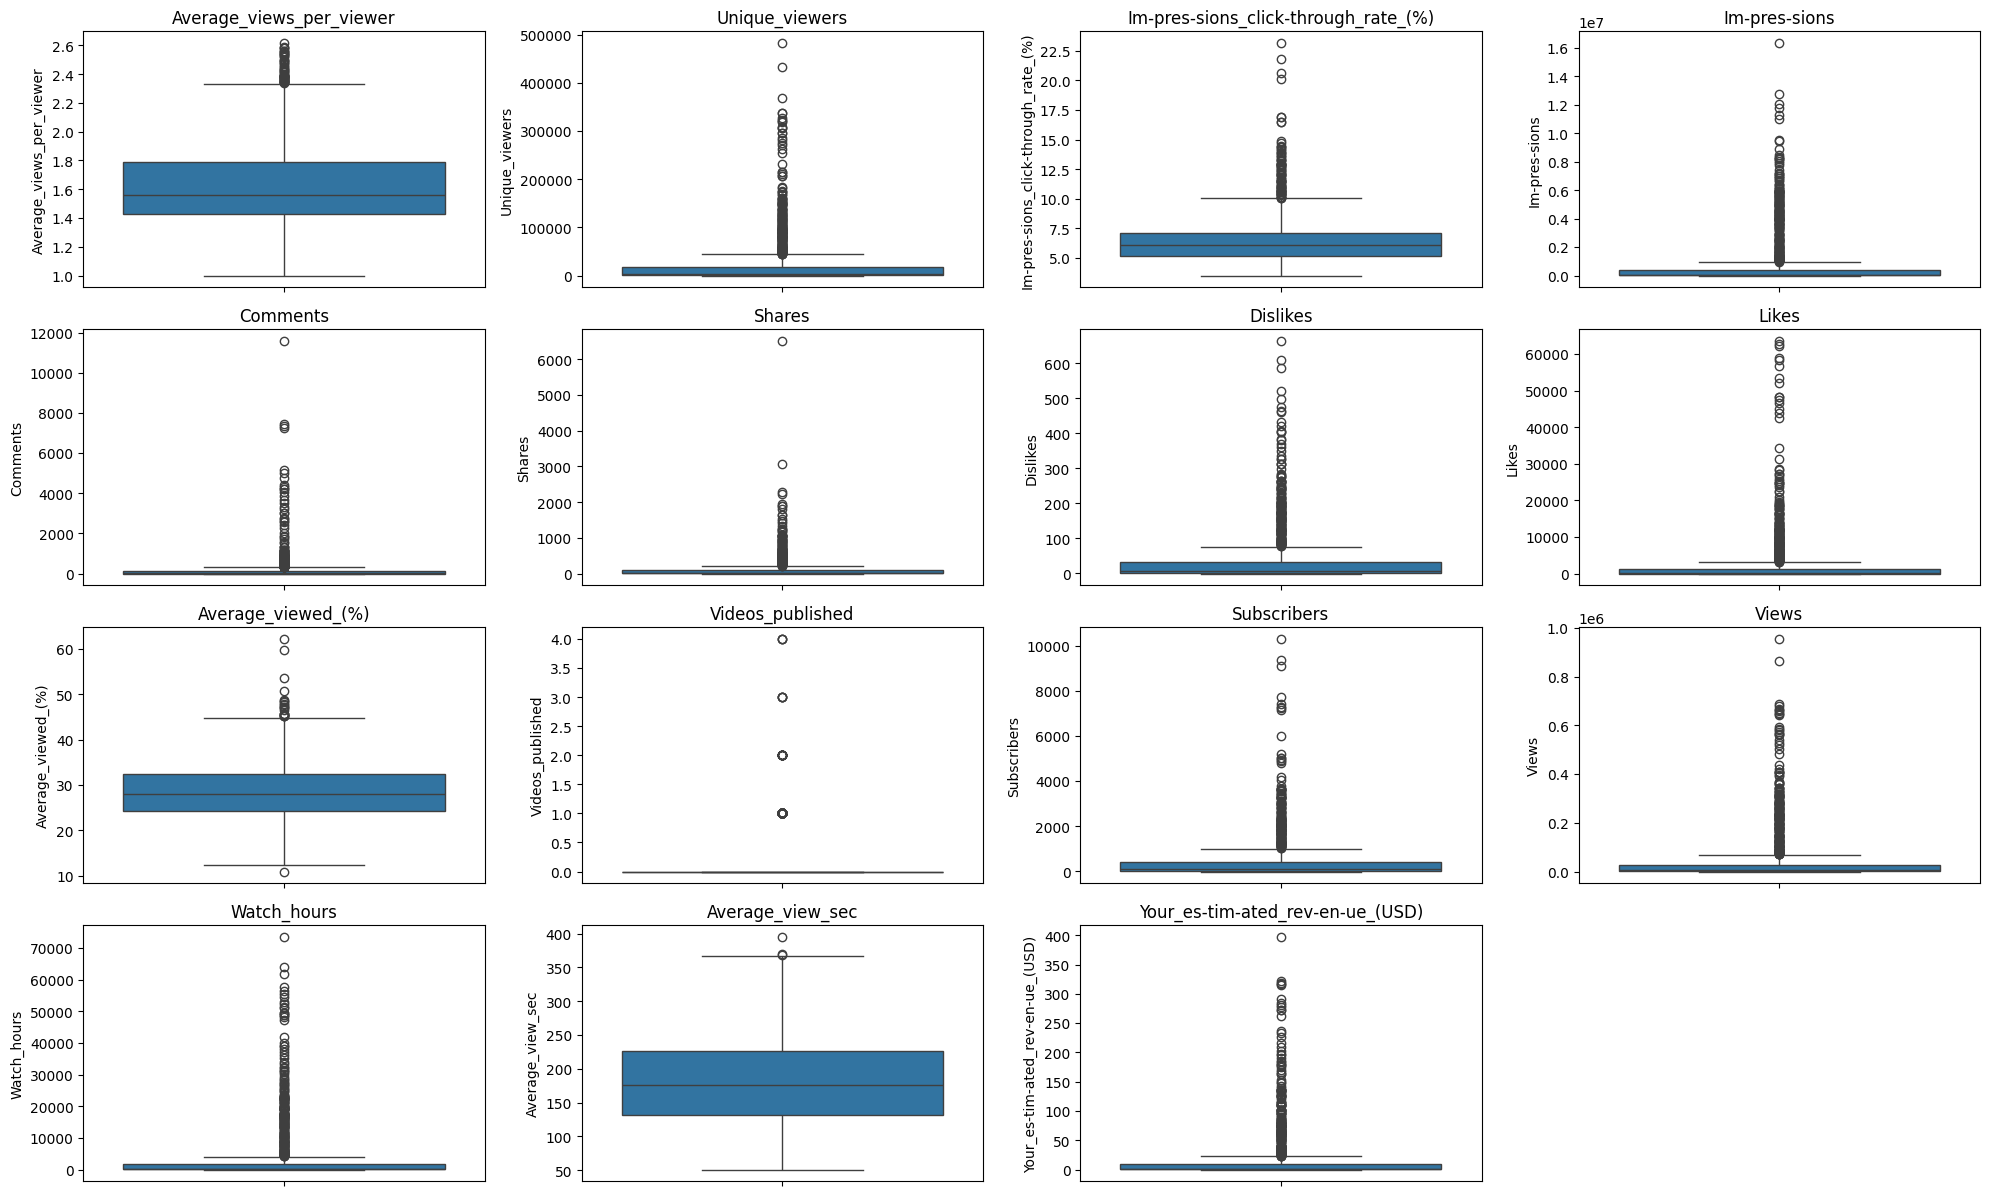

In [ ]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# Vẽ biểu đồ hộp cho các cột số để trực quan hóa các giá trị ngoại lai
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols):
    plt.subplot(5, 4, i + 1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

Xác định các cột có giá trị âm có khả năng không hợp lệ và lọc DataFrame để kiểm tra các hàng chứa các giá trị này.



In [ ]:
# Xác định tất cả các cột số
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# Loại trừ 'Ngày' và 'Người đăng ký' khỏi kiểm tra giá trị âm
cols_to_check = [col for col in numerical_cols if col not in ['Date', 'Subscribers']]

# Kiểm tra từng cột số được chỉ định để tìm giá trị âm
print("Checking numerical columns (excluding Date and Subscribers) for negative values:")
print("="*65)
found_negative = False
for col in cols_to_check:
    if (df[col] < 0).any():
        print(f"Rows with negative values in '{col}':")
        display(df[df[col] < 0])
        found_negative = True

if not found_negative:
    print("No negative values found in specified numerical columns.")

Checking numerical columns (excluding Date and Subscribers) for negative values:
Rows with negative values in 'Dislikes':


,Date,Average_views_per_viewer,Unique_viewers,Im­pres­sions_click-through_rate_(%),Im­pres­sions,Comments,Shares,Dislikes,Likes,Average_viewed_(%),Videos_published,Subscribers,Views,Watch_hours,Average_view_sec,Your_es­tim­ated_rev­en­ue_(USD)
395,2019-09-21,1.4414,478.0,6.27,8913.0,1.0,1.0,-1.0,7.0,23.85,0.0,1.0,689.0,22.7343,118.0,0.359


Rows with negative values in 'Likes':


,Date,Average_views_per_viewer,Unique_viewers,Im­pres­sions_click-through_rate_(%),Im­pres­sions,Comments,Shares,Dislikes,Likes,Average_viewed_(%),Videos_published,Subscribers,Views,Watch_hours,Average_view_sec,Your_es­tim­ated_rev­en­ue_(USD)
80,2018-11-09,1.3125,16.0,5.68,229.0,0.0,0.0,0.0,-1.0,26.53,0.0,0.0,21.0,0.7675,131.0,0.000
85,2018-11-14,1.1143,35.0,9.15,306.0,0.0,0.0,1.0,-1.0,27.94,0.0,0.0,39.0,1.5015,138.0,0.000
425,2019-10-21,1.5634,355.0,6.01,7089.0,1.0,2.0,1.0,-1.0,25.91,0.0,1.0,555.0,20.2166,131.0,0.186


Đối với tập dữ liệu này, việc thay thế các giá trị âm bằng 0.

In [ ]:
# Thay thế các giá trị âm trong các cột được chỉ định bằng 0
for col in cols_to_check:
    df[col] = df[col].apply(lambda x: 0 if x < 0 else x)

# Xác minh rằng không còn giá trị âm nào trong các cột được chỉ định
print("Negative values after handling:")
for col in cols_to_check:
    print(f"'{col}': {(df[col] < 0).sum()}")

Negative values after handling:
'Average_views_per_viewer': 0
'Unique_viewers': 0
'Im­pres­sions_click-through_rate_(%)': 0
'Im­pres­sions': 0
'Comments': 0
'Shares': 0
'Dislikes': 0
'Likes': 0
'Average_viewed_(%)': 0
'Videos_published': 0
'Views': 0
'Watch_hours': 0
'Average_view_sec': 0
'Your_es­tim­ated_rev­en­ue_(USD)': 0


Xử lý ngoại lai bằng biến đổi Logarit

Biến đổi logarit hiệu quả nhất với dữ liệu có phân phối bị lệch phải (right-skewed). Nó giúp "kéo" đuôi bên phải lại gần hơn và làm cho phân phối đối xứng hơn.

In [ ]:
# Identify numerical columns that might benefit from log transformation (right-skewed)
cols_to_log_transform = [
    'Unique_viewers', 'Im­pres­sions', 'Subscribers', 'Comments', 'Shares',
    'Dislikes', 'Likes', 'Views', 'Watch_hours', 'Your_es­tim­ated_rev­en­ue_(USD)'
]

# Apply np.log1p (log(1+x)) and replace original columns
for col in cols_to_log_transform:
    # Check if the column exists in the DataFrame
    if col in df.columns:
        # Check for negative values before applying log1p (log1p handles 0)
        if (df[col] < 0).any().any():
            print(f"Warning: Column '{col}' contains negative values. Log transformation might not be appropriate without prior handling.")
            # Ensure negative values are handled, e.g., replaced by 0 before log transformation
            df[col] = df[col].apply(lambda x: 0 if x < 0 else x)


        # Apply log1p transformation and create new column with _log suffix
        df[col + '_log'] = np.log1p(df[col])
        print(f"Applied log1p transformation to '{col}'. New column: '{col}_log'")

# Drop the original columns that were log-transformed
df = df.drop(columns=cols_to_log_transform)


# Display the head of the DataFrame to see the new log-transformed columns
display(df.head())

# Display descriptive statistics for the log-transformed columns to see the effect
print("\nDescriptive statistics for log-transformed columns:")
display(df[[col + '_log' for col in cols_to_log_transform if col + '_log' in df.columns]].describe())

Applied log1p transformation to 'Unique_viewers'. New column: 'Unique_viewers_log'
Applied log1p transformation to 'Im­pres­sions'. New column: 'Im­pres­sions_log'
Applied log1p transformation to 'Subscribers'. New column: 'Subscribers_log'
Applied log1p transformation to 'Comments'. New column: 'Comments_log'
Applied log1p transformation to 'Shares'. New column: 'Shares_log'
Applied log1p transformation to 'Dislikes'. New column: 'Dislikes_log'
Applied log1p transformation to 'Likes'. New column: 'Likes_log'
Applied log1p transformation to 'Views'. New column: 'Views_log'
Applied log1p transformation to 'Watch_hours'. New column: 'Watch_hours_log'
Applied log1p transformation to 'Your_es­tim­ated_rev­en­ue_(USD)'. New column: 'Your_es­tim­ated_rev­en­ue_(USD)_log'


,Date,Average_views_per_viewer,Im­pres­sions_click-through_rate_(%),Average_viewed_(%),Videos_published,Average_view_sec,Unique_viewers_log,Im­pres­sions_log,Subscribers_log,Comments_log,Shares_log,Dislikes_log,Likes_log,Views_log,Watch_hours_log,Your_es­tim­ated_rev­en­ue_(USD)_log
0,2018-08-21,1.1538,7.38,53.59,1.0,111.0,2.639057,4.812184,1.791759,1.098612,0.693147,0.0,1.791759,2.772589,0.382947,0.0
1,2018-08-22,1.1935,23.14,44.58,0.0,93.0,3.465736,4.804021,1.609438,1.386294,0.000000,0.0,1.609438,3.637586,0.671668,0.0
2,2018-08-23,1.3684,20.65,38.75,0.0,80.0,2.995732,4.532599,1.098612,0.693147,0.000000,0.0,1.791759,3.295837,0.460521,0.0
3,2018-08-24,1.0000,13.64,24.81,0.0,51.0,2.197225,3.806662,0.000000,0.000000,0.000000,0.0,0.000000,2.197225,0.109034,0.0
4,2018-08-25,1.0625,13.89,45.50,0.0,95.0,2.833213,4.290459,0.693147,0.000000,0.000000,0.0,0.000000,2.890372,0.370943,0.0



Descriptive statistics for log-transformed columns:


,Unique_viewers_log,Im­pres­sions_log,Subscribers_log,Comments_log,Shares_log,Dislikes_log,Likes_log,Views_log,Watch_hours_log,Your_es­tim­ated_rev­en­ue_(USD)_log
count,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000
mean,8.099093,11.064186,4.190602,3.205577,2.958306,2.117473,5.266333,8.566272,5.600424,1.521571
std,2.394468,2.734481,2.476983,2.257156,2.077014,1.815680,2.749482,2.551727,2.719852,1.568942
min,2.197225,3.806662,0.000000,0.000000,0.000000,0.000000,0.000000,2.197225,0.109034,0.000000
25%,6.127959,9.044286,1.945910,1.098612,1.098612,0.519860,2.772589,6.485397,3.157646,0.182946
50%,8.322635,11.139874,4.779123,3.367296,3.135494,1.945910,5.554894,8.772067,5.698330,0.948564
75%,9.803857,12.895665,6.029480,4.861743,4.477337,3.465736,7.128692,10.235668,7.389271,2.309443
max,13.086228,16.608116,9.239705,9.357294,8.781709,6.499787,11.059488,13.768547,11.204652,5.986618


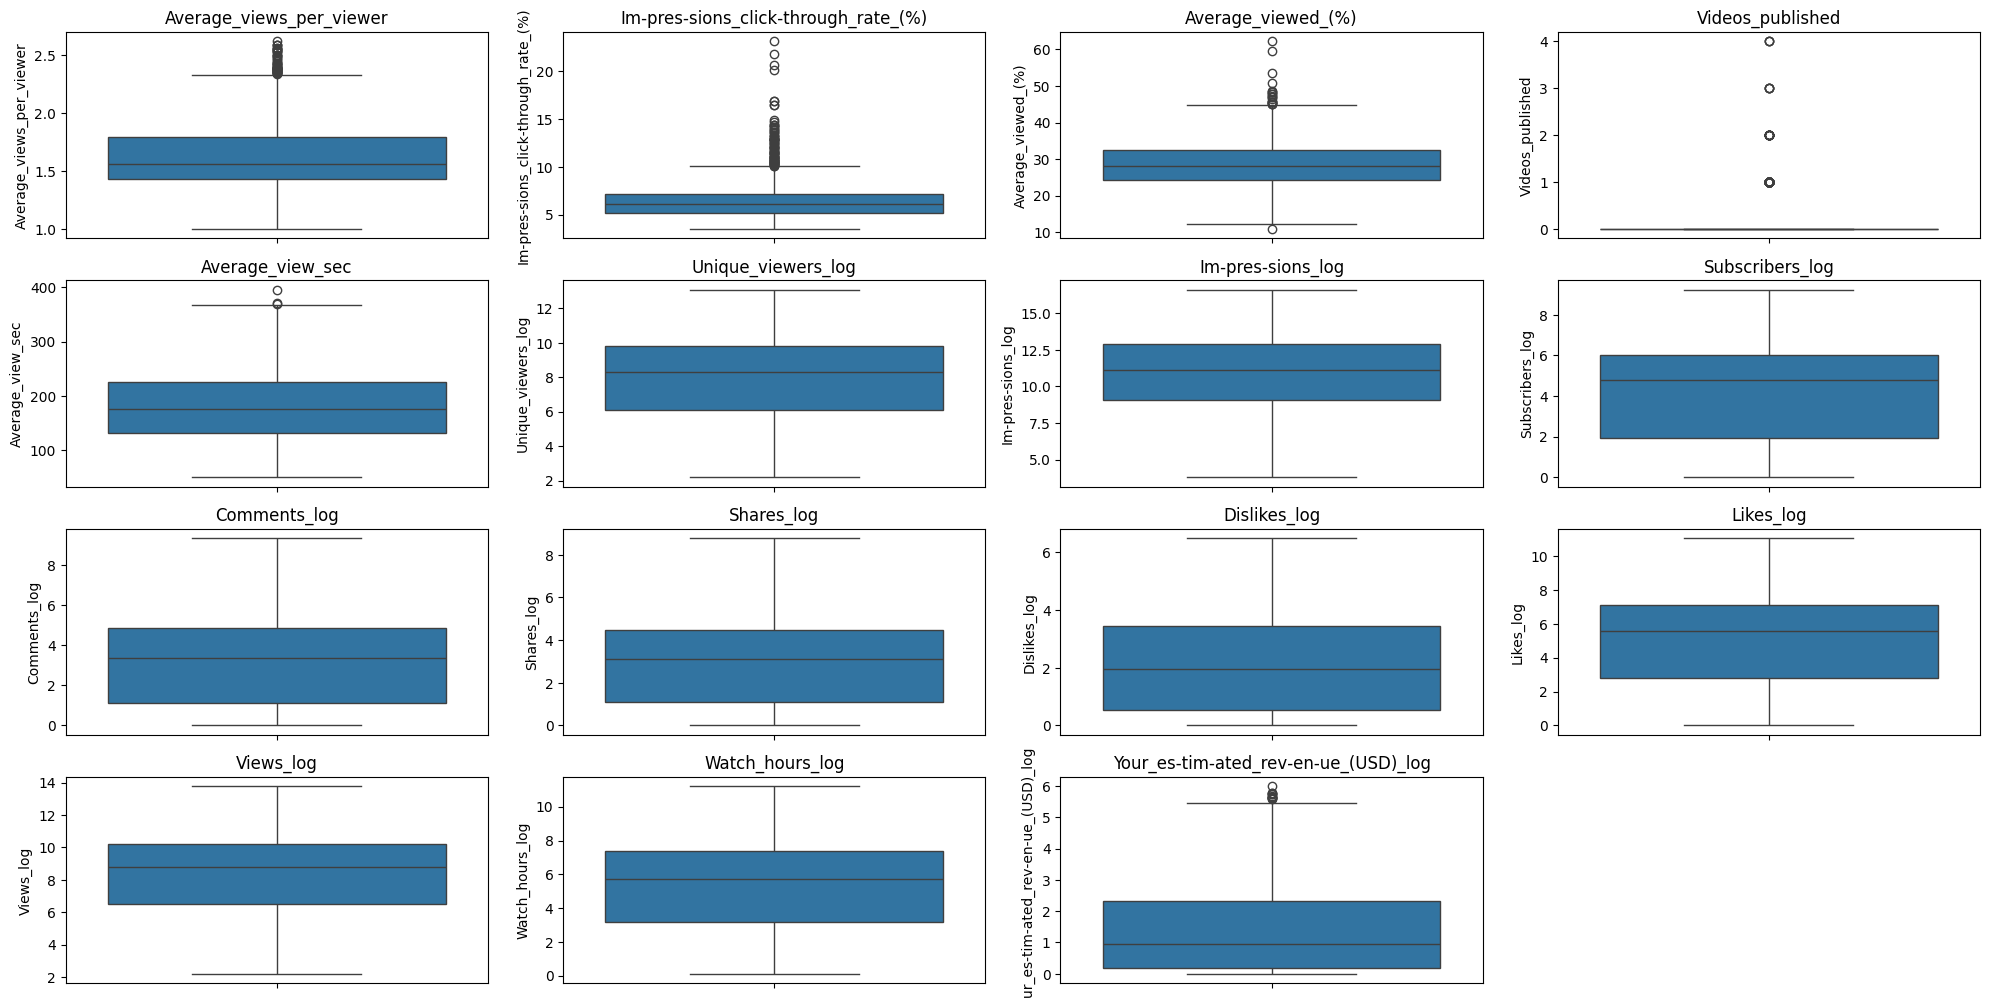

In [ ]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# Plot box plots for numerical columns to visualize outliers
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols):
    plt.subplot(6, 4, i + 1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

## 1.4. Chuẩn hóa giá trị


Tùy thuộc vào mô hình sẽ sử dụng, có thể cần chuẩn hóa (scaling) các đặc trưng số hoặc tạo ra các đặc trưng mới từ dữ liệu hiện có.


**Reasoning**:
Create new date-based features, identify numerical columns, scale the numerical columns using StandardScaler, and display the first 5 rows of the updated dataframe.



In [ ]:
from sklearn.preprocessing import StandardScaler

# Identify numerical columns for scaling, excluding the new date features and the target variable 'Revenue' if it is not a feature
numerical_cols_to_scale = df.select_dtypes(include=np.number).columns.tolist()
# Assuming 'Revenue' is the target and should not be scaled as a feature
if 'Your_es­tim­ated_rev­en­ue_(USD)_log' in numerical_cols_to_scale:
    numerical_cols_to_scale.remove('Your_es­tim­ated_rev­en­ue_(USD)_log')


# Apply StandardScaler to the selected numerical columns
scaler = StandardScaler()
df[numerical_cols_to_scale] = scaler.fit_transform(df[numerical_cols_to_scale])



In [ ]:
display(df.head())

,Date,Average_views_per_viewer,Im­pres­sions_click-through_rate_(%),Average_viewed_(%),Videos_published,Average_view_sec,Unique_viewers_log,Im­pres­sions_log,Subscribers_log,Comments_log,Shares_log,Dislikes_log,Likes_log,Views_log,Watch_hours_log,Your_es­tim­ated_rev­en­ue_(USD)_log
0,2018-08-21,-1.453602,0.361301,4.045147,1.84692,-1.206960,-2.281279,-2.287368,-0.968882,-0.933872,-1.091066,-1.166731,-1.264278,-2.271499,-1.919143,0.0
1,2018-08-22,-1.331710,7.379270,2.576267,-0.32864,-1.508290,-1.935881,-2.290355,-1.042521,-0.806363,-1.424937,-1.166731,-1.330618,-1.932364,-1.812942,0.0
2,2018-08-23,-0.794707,6.270466,1.625816,-0.32864,-1.725916,-2.132255,-2.389658,-1.248841,-1.113587,-1.424937,-1.166731,-1.264278,-2.066352,-1.890609,0.0
3,2018-08-24,-1.925821,3.148895,-0.646789,-0.32864,-2.211392,-2.465883,-2.655250,-1.692565,-1.420812,-1.424937,-1.166731,-1.916238,-2.497079,-2.019896,0.0
4,2018-08-25,-1.733925,3.260221,2.726253,-0.32864,-1.474808,-2.200158,-2.478248,-1.412606,-1.420812,-1.424937,-1.166731,-1.916238,-2.225320,-1.923558,0.0
